# Plots from March 2021 FreeDOM Reco

In [1]:
import tables
import numpy as np
import dragoman as dm
from matplotlib import pyplot as plt
from freedom.utils.i3frame_dataloader import DEFAULT_LABELS as parnames

In [2]:
params = {'legend.fontsize': 16,
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14}
plt.rcParams.update(params)

In [3]:
def fill_variable_dict(name, node, var_dict, n_evts):
    print(f"Loading {name}")
    
    if 'vector_index' in node.colnames:
        n_rows = n_evts * len(parnames)
        for par, parname in zip(node.cols.item[:n_rows].reshape((-1, len(parnames))).T,
                                parnames):
            var_dict[f"{name}_{parname}"] = par
    elif 'value' in node.colnames:
        var_dict[name] = node.cols.value[:n_evts]
    else:
        var_dict[name] = node.read(start=0, stop=n_evts)

def unpack_file_data(file, n_evts=None):
    root = file.root
    
    if n_evts is None:
        n_evts = root.FreeDOM_test_best_LLH.nrows
        
    var_dict = {}
    for node in root:
        try:
            col_names = node.colnames
        except tables.NoSuchNodeError:
            continue

        name = node.name.replace('FreeDOM_test_', '').replace('_params', '')
        name = name.replace('best_fit', 'freedom')
        fill_variable_dict(name, node, var_dict, n_evts)
        
    return var_dict

def load_file(f_name, n_evts=None):
    with tables.File(f_name) as file:
        return dm.PointData(**unpack_file_data(file, n_evts))

In [4]:
%%time
d = load_file('/data/atfienberg/freeDOM/i3_reco/freeDOM_3_21_full_with_weights.hdf5')
print(f'Loaded {d.size} events')

Loading best_LLH
Loading freedom
Loading delta_T
Loading env_mins
Loading env_p2
Loading env_resid_rms
Loading means
Loading n_crs_iters
Loading n_llh_calls
Loading stds
Loading truth_LLH
Loading I3MCWeightDict
Loading L5_SANTA_DirectPulsesHitMultiplicity
Loading L7_AllPhotons_PhotonSpeedMetrics
Loading L7_CoincidentMuon_Variables
Loading L7_CoincidentMuon_bool
Loading L7_MuonClassifier_ProbNu
Loading L7_PIDClassifier_ProbTrack
Loading L7_reconstructed_time
Loading L7_reconstructed_total_energy
Loading L7_reconstructed_vertex_rho36
Loading L7_reconstructed_vertex_z
Loading L7_reconstructed_zenith
Loading MCDeepCoreStartingEvent
Loading MCInIcePrimary
Loading interaction_type
Loading pdg_id
Loading retro
Loading true
Loaded 8010633 events
CPU times: user 2min 24s, sys: 20.8 s, total: 2min 44s
Wall time: 2min 45s


### Access data in I3MCWeightDict, MCInIcePrimary, L5_SANTA_DirectPulsesHitMultiplicity, etc by key:

In [5]:
d['MCInIcePrimary']['energy'][:4]

2.7,3.57,3.69,1.76


In [6]:
d['MCInIcePrimary']['zenith'][:4]

1.98,2.52,2.89,1.88


In [7]:
d['I3MCWeightDict']['PrimaryNeutrinoEnergy'][:4]

2.7,3.57,3.69,1.76


Check what keys are available in L5_SANTA_DirectPulsesHitMultiplicity:

In [8]:
d['L5_SANTA_DirectPulsesHitMultiplicity'].dtype.names

('Run',
 'Event',
 'SubEvent',
 'SubEventStream',
 'exists',
 'n_pulses',
 'n_hit_strings',
 'n_hit_doms',
 'n_hit_doms_one_pulse')

In [9]:
d['L5_SANTA_DirectPulsesHitMultiplicity']['n_hit_doms'][:4]

5,6,4,0


In [10]:
for name in ['retro', 'true', 'freedom']:
    d[f'{name}_total_energy'] = d[f'{name}_cascade_energy'] + d[f'{name}_track_energy']

In [11]:
def reco_comparison(parname, bins, x_lim=None, y_lim=None, log_x=False, log_y=False):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    axes = axes.flatten()
    reco_pars = [f'retro_{parname}', f'freedom_{parname}']
    true_par = f'true_{parname}'
    for i, reco_par in enumerate(reco_pars):
        sub_d = d[[true_par, reco_par]]
        
        cmap='Greens' if 'retro' in reco_par else 'Blues'
        sub_d.histogram(**{true_par:bins}, **{reco_par:bins}).plot('counts', cmap=cmap, ax=axes[2*i])
        sub_d.binwise(**{true_par:bins}).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95]).plot_bands(reco_par,
                                                                                              cmap=cmap,
                                                                                              ax=axes[2*i + 1],
                                                                                              labels=['IQ90', 'IQ50', 'median'])
        axes[2*i + 1].legend()
            
    for ax in axes:
        if log_x:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')

        if x_lim is not None:
            ax.set_xlim(*x_lim)
        if y_lim is not None:
            ax.set_ylim(*y_lim)
            
        x_lim = ax.get_xlim()
        ax.plot(x_lim, x_lim, 'r--')


CPU times: user 6.31 s, sys: 6.88 s, total: 13.2 s
Wall time: 13.2 s


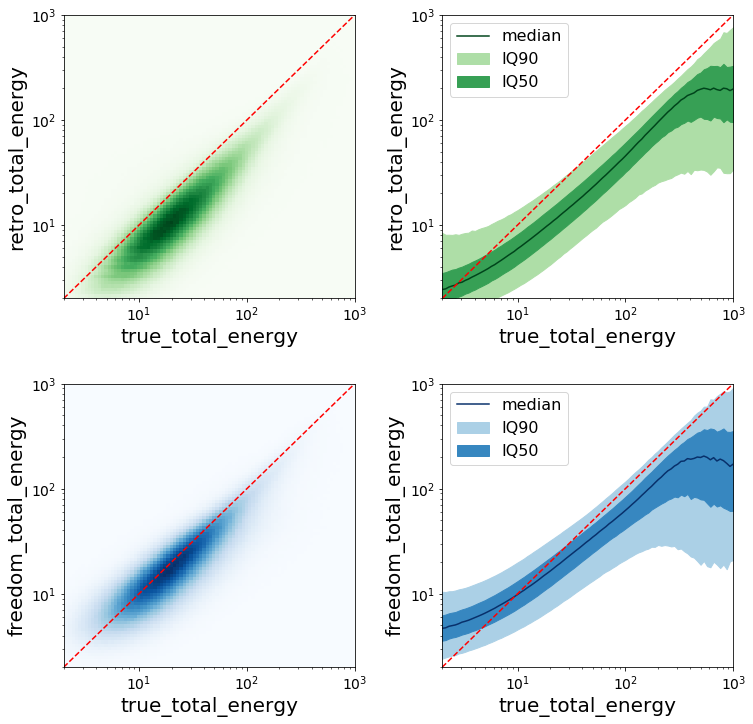

In [12]:
%%time
reco_comparison('total_energy', bins=np.logspace(0, 3, 100), 
                x_lim=(2, 1000), y_lim=(2, 1000), log_x=True, log_y=True)

CPU times: user 5.62 s, sys: 6.59 s, total: 12.2 s
Wall time: 12.2 s


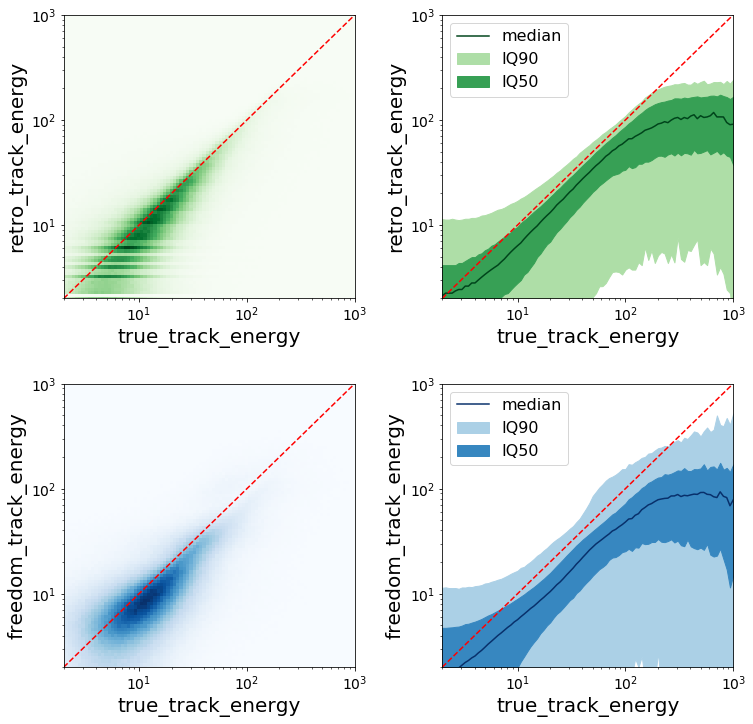

In [13]:
%%time
reco_comparison('track_energy', bins=np.logspace(0, 3, 100), 
                x_lim=(2, 1000), y_lim=(2, 1000), log_x=True, log_y=True)

CPU times: user 7.22 s, sys: 7.36 s, total: 14.6 s
Wall time: 14.6 s


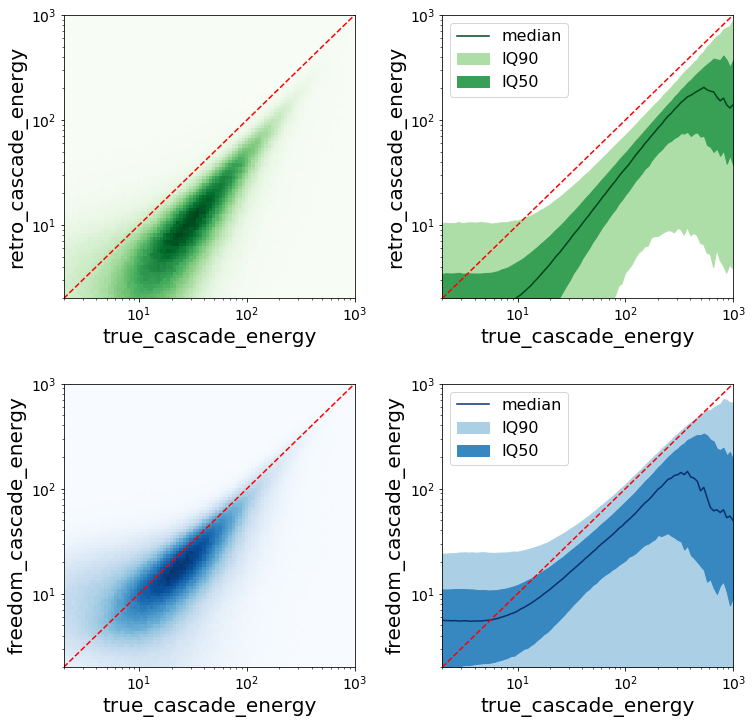

In [14]:
%%time
reco_comparison('cascade_energy', bins=np.logspace(0, 3, 100), 
                x_lim=(2, 1000), y_lim=(2, 1000), log_x=True, log_y=True)

CPU times: user 9.59 s, sys: 11 s, total: 20.6 s
Wall time: 20.6 s


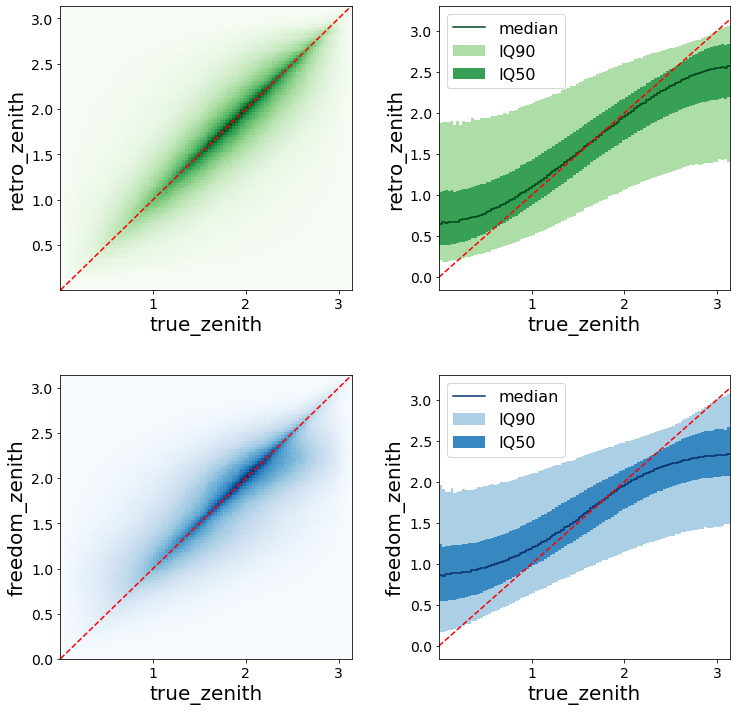

In [15]:
%%time
reco_comparison('zenith', bins=100)

CPU times: user 11.5 s, sys: 11 s, total: 22.5 s
Wall time: 22.6 s


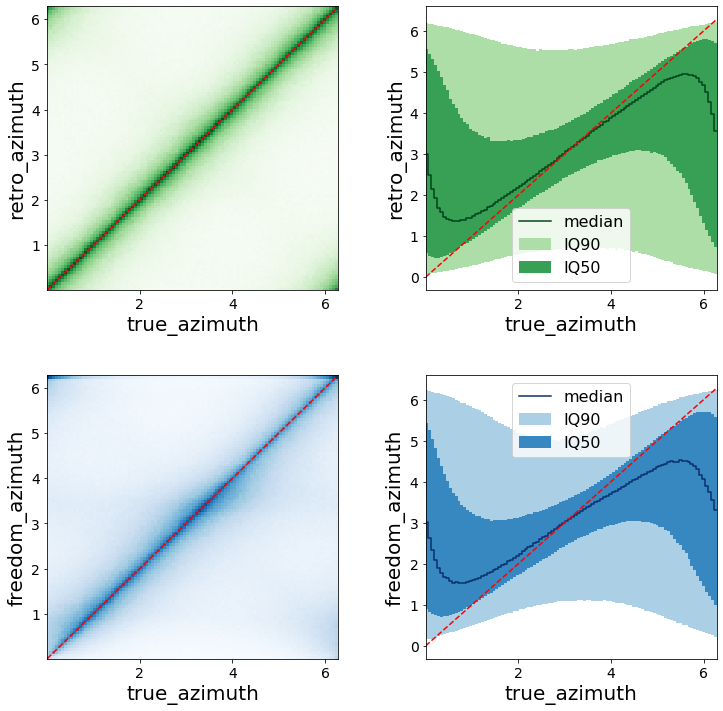

In [16]:
%%time
reco_comparison('azimuth', bins=100)
plt.savefig('az_response.png', bbox_inches='tight')

CPU times: user 16.9 s, sys: 10.9 s, total: 27.8 s
Wall time: 27.8 s


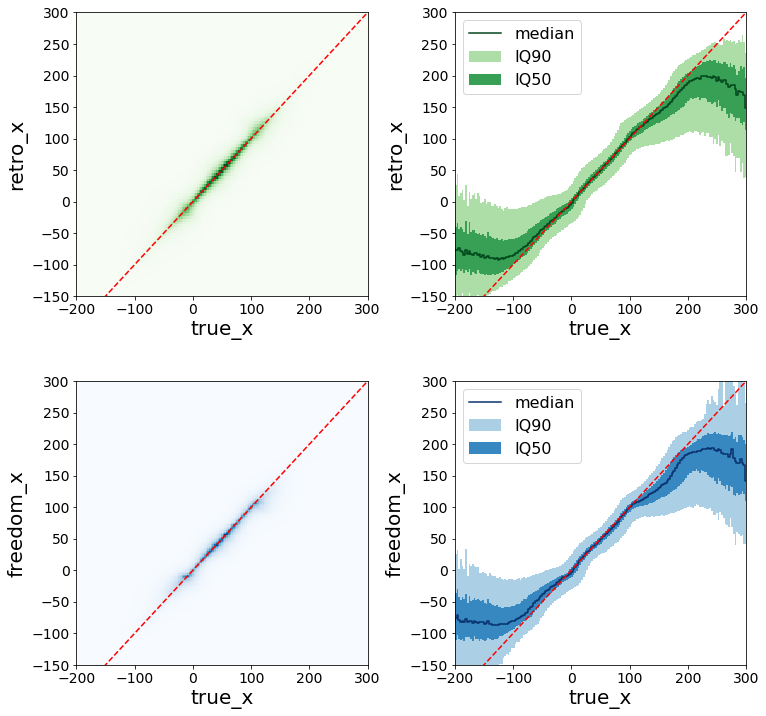

In [17]:
%%time
reco_comparison('x', bins=500, x_lim=(-200, 300), y_lim=(-150, 300))

CPU times: user 17 s, sys: 11 s, total: 28.1 s
Wall time: 28.1 s


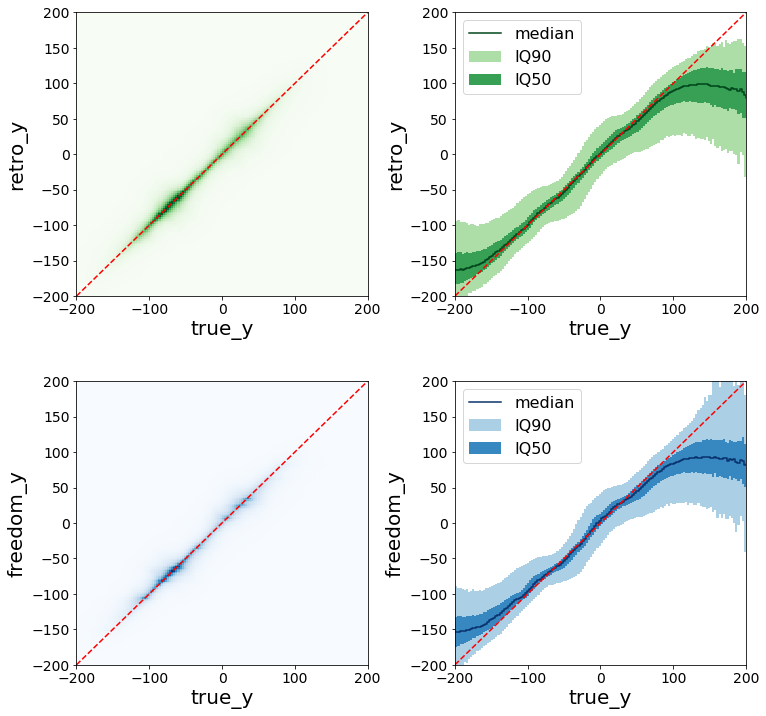

In [18]:
%%time
reco_comparison('y', bins=500, x_lim=(-200, 200), y_lim=(-200, 200))

### Add derived uncertainty estimates to the dataset

In [19]:
for par in parnames:
    p2s = np.where(d[f'env_p2_{par}'] > 0, d[f'env_p2_{par}'], 1e-9)
    d[f'unc_ests_{par}'] = 1/np.sqrt(2*p2s)

CPU times: user 3.29 s, sys: 5.39 s, total: 8.68 s
Wall time: 8.68 s


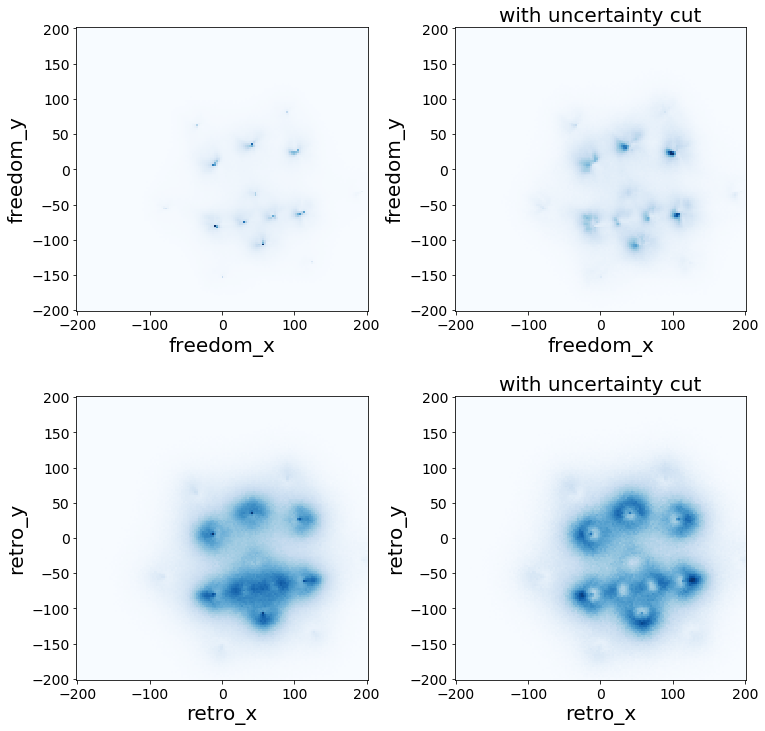

In [20]:
%%time
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()
bins = np.linspace(-200, 200, 150)
cut_val = 1.5
for i, reco in enumerate(['freedom', 'retro']):
    ax = axes[2*i]
    x_key, y_key = f'{reco}_x', f'{reco}_y'
    sub_d = d[[x_key, y_key]]
    hist = sub_d.histogram(**{x_key:bins, y_key:bins}).plot(cmap='Blues', ax=axes[2*i])
    
    ax = axes[2*i+1]
    cut_sub_d = sub_d[(d['unc_ests_x'] > cut_val) & (d['unc_ests_y'] > cut_val)]
    hist = cut_sub_d.histogram(**{x_key:bins, y_key:bins}).plot(cmap='Blues', ax=ax)
    ax.set_title(f"with uncertainty cut")

CPU times: user 1.95 s, sys: 2.97 s, total: 4.92 s
Wall time: 4.91 s


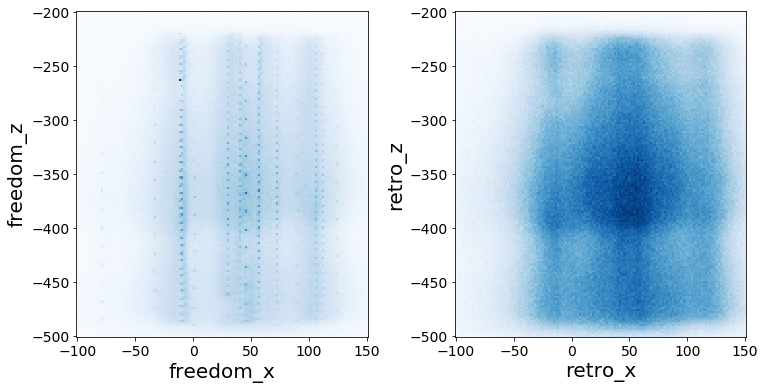

In [21]:
%%time
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()
z_bins = np.linspace(-500, -200, 150)
x_bins = np.linspace(-100, 150, 150)
cut_val = 1.5
for i, reco in enumerate(['freedom', 'retro']):
    ax = axes[i]
    x_key, z_key = f'{reco}_x', f'{reco}_z'
    sub_d = d[[x_key, z_key]]
    hist = sub_d.histogram(**{x_key:x_bins, z_key:z_bins}).plot(cmap='Blues', ax=axes[i])

In [22]:
for reco in ['freedom', 'retro']:
    reco_x = d[f'{reco}_x']
    reco_y = d[f'{reco}_y']
    
    true_x = d['true_x']
    true_y = d['true_y']
    
    rho_dist = np.sqrt((reco_x - true_x)**2 + (reco_y - true_y)**2)
    
    d[f'{reco}_rho_dist'] = rho_dist
    
    d[f'{reco}_z_dist'] = d[f'{reco}_z'] - d['true_z']

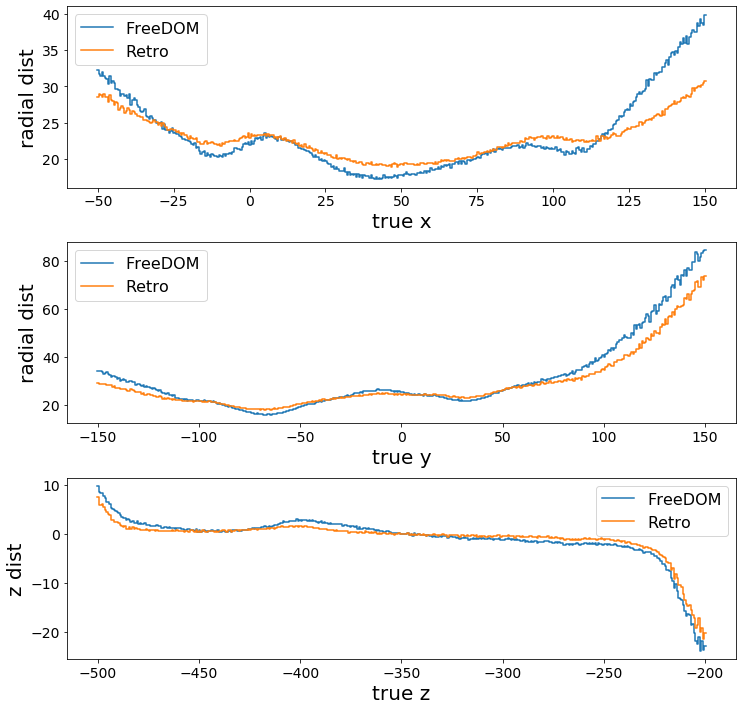

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3)
axiter = axes.flat
x_bins = np.linspace(-50, 150, 400)
y_bins = np.linspace(-150, 150, 400)
z_bins = np.linspace(-500, -200, 400)
for coord, bins in zip(['x', 'y', 'z'], (x_bins, y_bins, z_bins)):
    ax = next(axiter)
    true_var = f'true_{coord}'
    
    dist_var = 'rho_dist' if coord != 'z' else 'z_dist'
        
    binwise_means = d[[f'freedom_{dist_var}', f'retro_{dist_var}', true_var]].binwise(**{true_var:bins}).mean()
    binwise_means.plot(f'freedom_{dist_var}', label='FreeDOM', ax=ax)
    binwise_means.plot(f'retro_{dist_var}', label='Retro', ax=ax)

    ax.legend()
    
    ax.set_xlabel(f'true {coord}')
    
    if coord != 'z':
        ax.set_ylabel('radial dist')
    else:
        ax.set_ylabel('z dist')

CPU times: user 3.41 s, sys: 4.4 s, total: 7.81 s
Wall time: 7.81 s


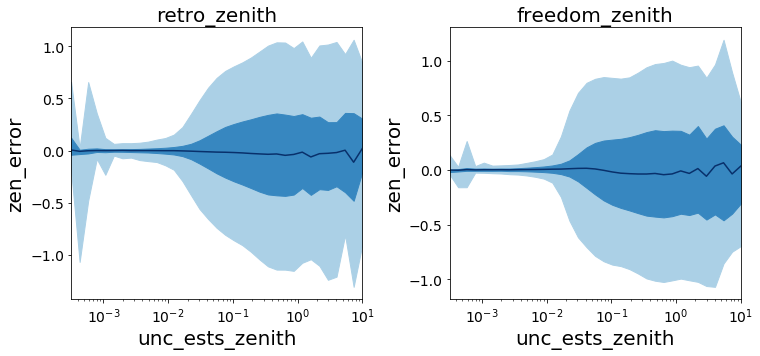

In [24]:
%%time
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.subplots_adjust(wspace=0.3)
unc_est_bins = np.logspace(-3.5, 1, 35)
for zen_var, ax in zip(['retro_zenith', 'freedom_zenith'], axes.flat):
    sub_d = d[['unc_ests_zenith']]
    sub_d['zen_error'] = d[zen_var] - d['true_zenith']
    sub_d.binwise(unc_ests_zenith=unc_est_bins).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95]).plot_bands('zen_error', ax=ax)
    
    ax.set_title(zen_var)
    ax.set_xscale('log')                                                                                      

Split by flavor & interaction type

In [25]:
def split_by_type():
    nc_q = d['interaction_type'] == 2
    nc = d[nc_q]
    cc = d[~nc_q]
    abs_id = np.abs(cc['pdg_id'])
    e_cc = cc[abs_id == 12]
    mu_cc = cc[abs_id == 14]
    tau_cc = cc[abs_id == 16]
    
    return nc, e_cc, mu_cc, tau_cc

In [26]:
%%time
nc, e_cc, mu_cc, tau_cc = split_by_type() 

CPU times: user 17.3 s, sys: 1min 35s, total: 1min 52s
Wall time: 1min 52s


In [27]:
nu_data = [nc, e_cc, mu_cc, tau_cc]
nu_labels = [r'$\nu_{all}^{NC}$', r'$\nu_e^{CC}$', r'$\nu_\mu^{CC}$', r'$\nu_\tau^{CC}$']

In [28]:
sum(type_d['true_x'].size for type_d in nu_data)

8010633

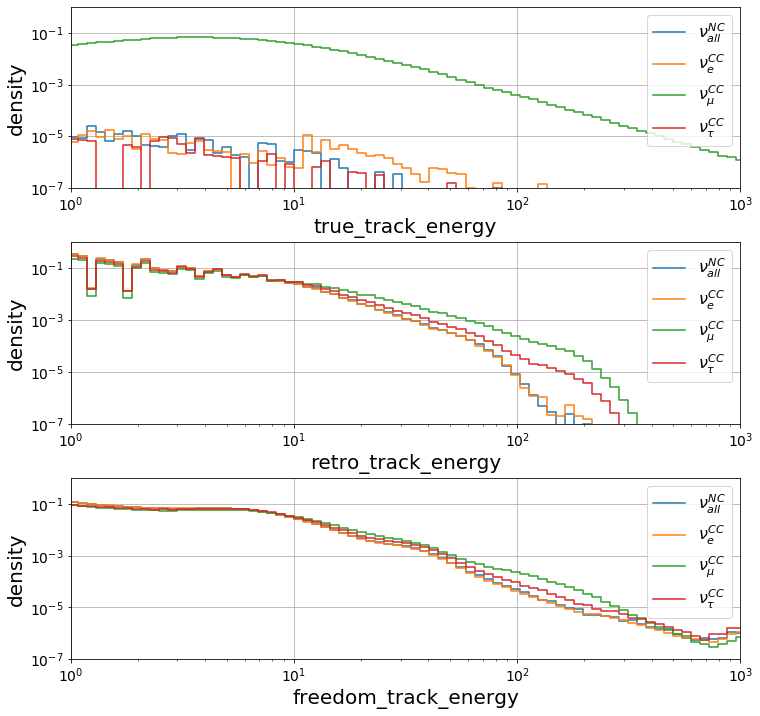

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3)
bins = np.logspace(-1, 3, 100)
bins[0] = -1

for ax, var in zip(axes.flat, ['true_track_energy', 'retro_track_energy', 'freedom_track_energy']):
    for dataset, label in zip(nu_data, nu_labels):
        track_e = dataset[[var]]
        track_e.histogram(**{var: bins}, density=True).plot('density', ax=ax, label=label)

    ax.legend()
    ax.grid()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, 1000)
    ax.set_ylim(1e-7, 1)

### Some random plots split by interaction type...

In [30]:
def plot_1d_by_type(par, bins, cut_low=None, cut_high=None, log_x=False, log_y=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
    
    for data, label in zip(nu_data, nu_labels):
        sub_data = data[[par]]
        if cut_low is not None:
            sub_data = sub_data[sub_data[par] > cut_low]
        if cut_high is not None:
            sub_data = sub_data[sub_data[par] < cut_high]
            
        mean = sub_data[par].mean()
        label = f'{label}, mean: {mean:.1f}'
        hist = sub_data.histogram(**{par:bins}, density=True).plot(label=label, ax=ax)
        
    ax.legend()
    
    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

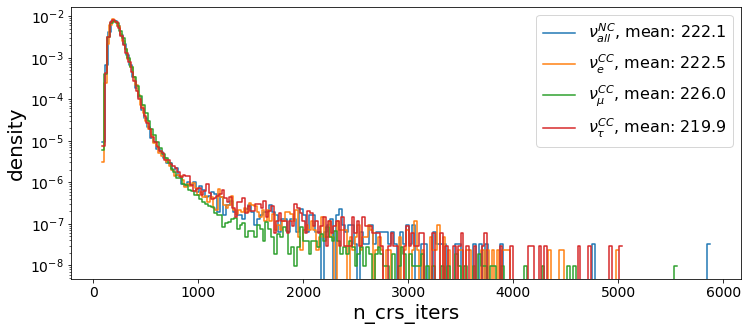

In [31]:
plot_1d_by_type('n_crs_iters', 200, log_y=True)
plt.savefig('n_iters.png', bbox_inches='tight')

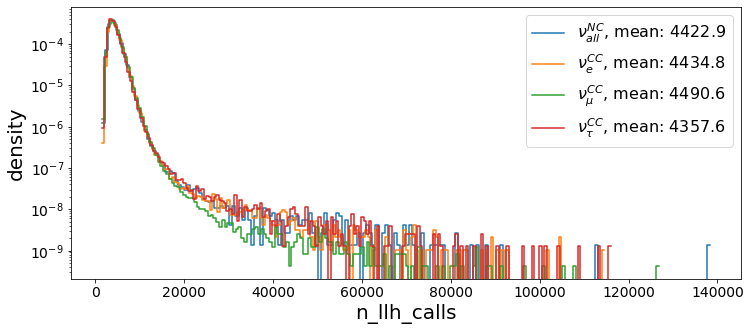

In [32]:
plot_1d_by_type('n_llh_calls', 200, log_y=True)
plt.savefig("n_calls.png", bbox_inches='tight')

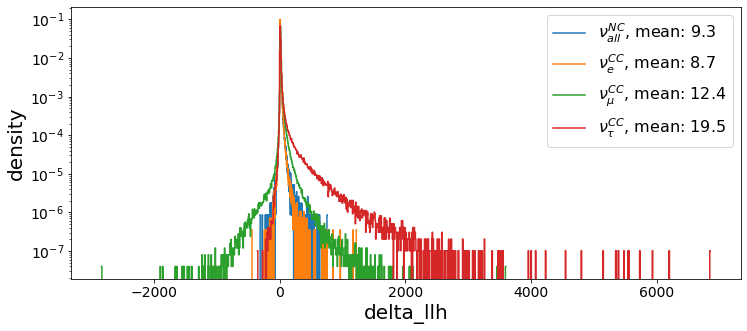

In [33]:
for data in nu_data:
    data['delta_llh'] = data['truth_LLH'] - data['best_LLH']
# this cut removes the fits that were seeded entirely out of the allowed search region
plot_1d_by_type('delta_llh', bins=1000, cut_high=1e8, log_y=True)

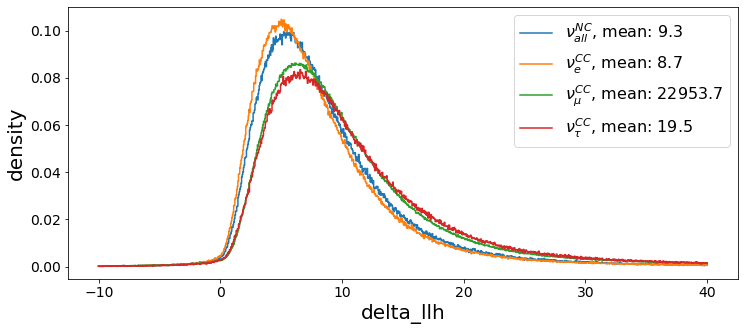

In [34]:
plot_1d_by_type('delta_llh', bins=np.linspace(-10, 40, 1000))

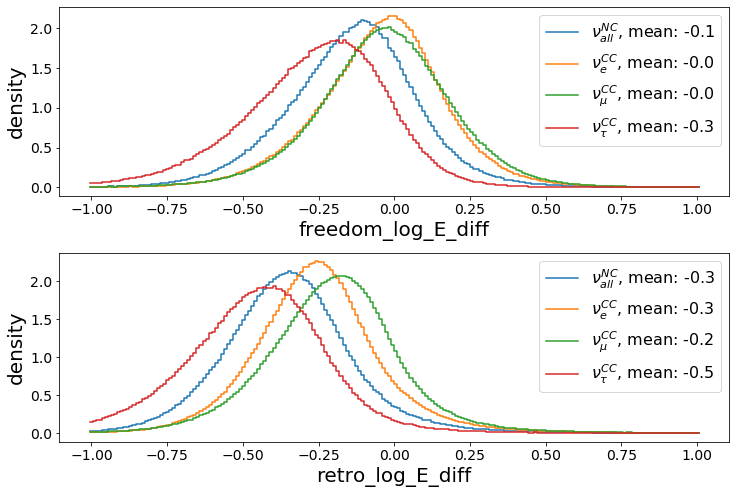

In [35]:
for data in nu_data:
    data['freedom_log_E_diff'] = np.log10(data['freedom_total_energy']) - np.log10(data['true_total_energy'])
    data['retro_log_E_diff'] = np.log10(data['retro_total_energy']) - np.log10(data['true_total_energy'])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3)
ax = ax.flatten()

plot_1d_by_type('freedom_log_E_diff', bins=np.linspace(-1, 1, 200), ax=ax[0])
plot_1d_by_type('retro_log_E_diff', bins=np.linspace(-1, 1, 200), ax=ax[1])

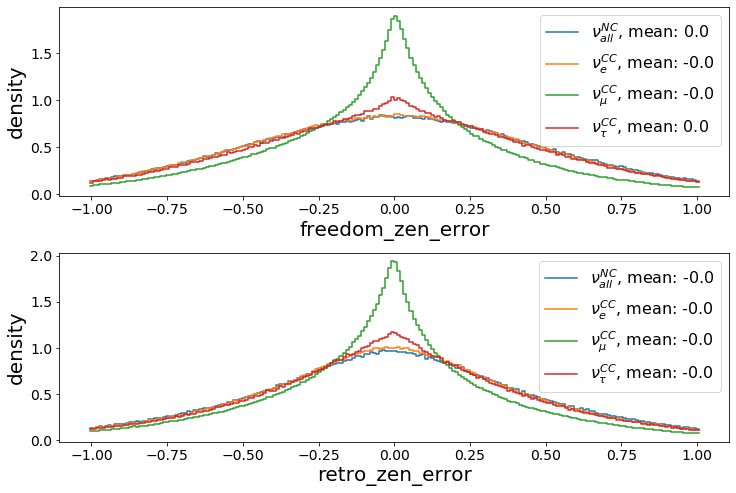

In [36]:
for data in nu_data:
    data['freedom_zen_error'] = data['freedom_zenith'] - data['true_zenith']
    data['retro_zen_error'] = data['retro_zenith'] - data['true_zenith']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3)
ax = ax.flatten()

plot_1d_by_type('freedom_zen_error', bins=np.linspace(-1, 1, 200), ax=ax[0])
plot_1d_by_type('retro_zen_error', bins=np.linspace(-1, 1, 200), ax=ax[1])